In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import collections
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!mkdir -p data
with ZipFile('digit-recognizer.zip', 'r') as zipObj:
   zipObj.extractall('data')

In [3]:
test_data = pd.read_csv('./data/test.csv')
train_data = pd.read_csv('./data/train.csv')

<BarContainer object of 10 artists>

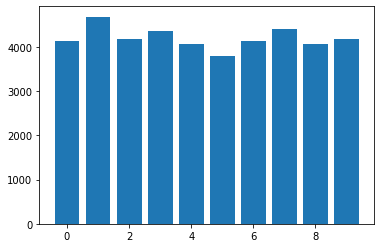

In [4]:
labels = train_data.label.values
train_labels = to_categorical(labels, num_classes = 10)
label_count = collections.Counter(labels)
plt.bar(label_count.keys(), label_count.values())

In [5]:
train_data.drop(columns={'label'}, inplace=True)
train_data /= 255.
test_data /= 255.

In [6]:
test_images = np.reshape(test_data.values, (test_data.shape[0],28,28,1))
train_images = np.reshape(train_data.values, (train_data.shape[0],28,28,1))
test_images[0].shape

(28, 28, 1)

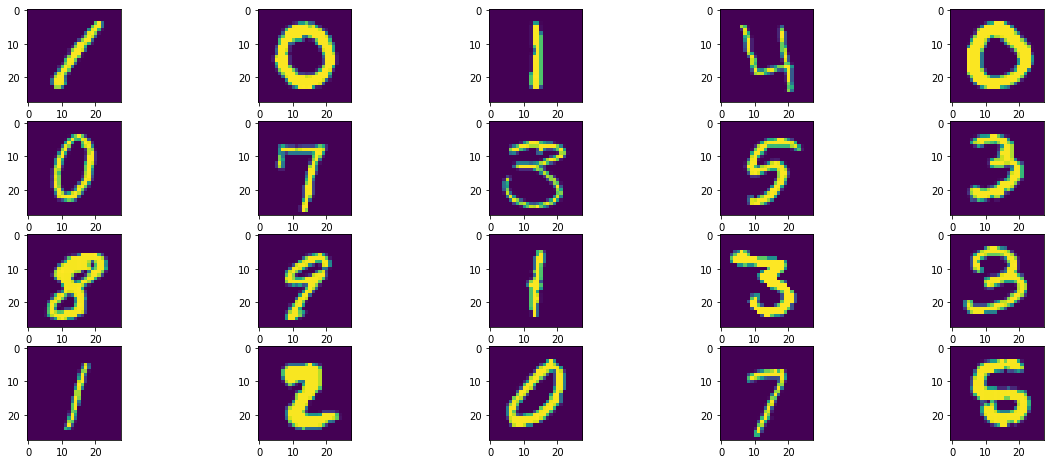

In [7]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(train_images[:20]):
    plt.subplot(len(train_images[:20]) / columns + 1, columns, i + 1)
    plt.imshow(image[:,:,0])

In [8]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.25, random_state=4)

In [22]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    
    opt = Adam(lr=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    return model 

In [23]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)         

In [24]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1)

datagen.fit(X_train)

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001)
 
# train the model
print("[INFO] training model...")
BS = 128
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BS), steps_per_epoch= X_train.shape[0] // BS, 
                    validation_data=(X_val, Y_val), epochs=30, verbose=2, callbacks=[reduce_lr])

[INFO] training model...
Train for 246 steps, validate on 10500 samples
Epoch 1/30
246/246 - 53s - loss: 0.0890 - accuracy: 0.9748 - val_loss: 0.0331 - val_accuracy: 0.9903
Epoch 2/30
246/246 - 53s - loss: 0.0770 - accuracy: 0.9767 - val_loss: 0.0368 - val_accuracy: 0.9894
Epoch 3/30
246/246 - 53s - loss: 0.0794 - accuracy: 0.9774 - val_loss: 0.0302 - val_accuracy: 0.9912
Epoch 4/30
246/246 - 53s - loss: 0.0810 - accuracy: 0.9770 - val_loss: 0.0353 - val_accuracy: 0.9910
Epoch 5/30
246/246 - 53s - loss: 0.0818 - accuracy: 0.9771 - val_loss: 0.0378 - val_accuracy: 0.9895
Epoch 6/30
246/246 - 52s - loss: 0.0784 - accuracy: 0.9773 - val_loss: 0.0281 - val_accuracy: 0.9921
Epoch 7/30
246/246 - 53s - loss: 0.0753 - accuracy: 0.9775 - val_loss: 0.0320 - val_accuracy: 0.9903
Epoch 8/30
246/246 - 52s - loss: 0.0725 - accuracy: 0.9788 - val_loss: 0.0353 - val_accuracy: 0.9913
Epoch 9/30
246/246 - 54s - loss: 0.0676 - accuracy: 0.9803 - val_loss: 0.0345 - val_accuracy: 0.9902
Epoch 10/30
246/246

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


<Figure size 1440x720 with 0 Axes>

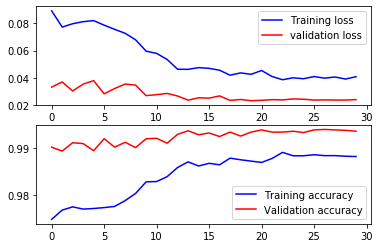

In [29]:
print(history.history.keys())
# Plot the loss and accuracy curves for training and validation 
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].legend()

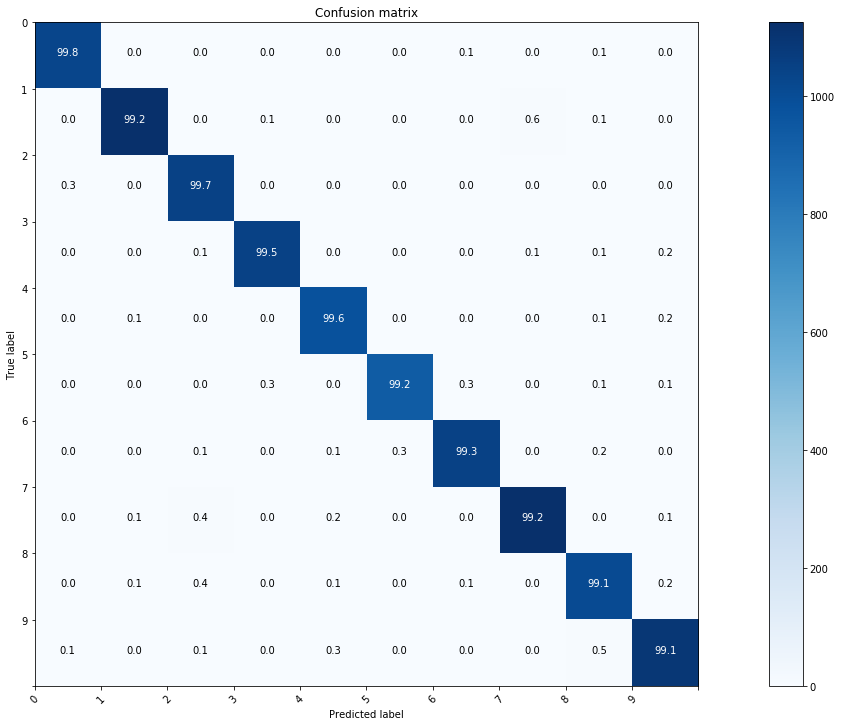

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],1)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize=True)

In [31]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       1.00      0.99      0.99      1134
           2       0.99      1.00      0.99      1049
           3       1.00      1.00      1.00      1052
           4       0.99      1.00      0.99       986
           5       1.00      0.99      0.99       944
           6       1.00      0.99      0.99      1055
           7       0.99      0.99      0.99      1132
           8       0.99      0.99      0.99      1017
           9       0.99      0.99      0.99      1100

    accuracy                           0.99     10500
   macro avg       0.99      0.99      0.99     10500
weighted avg       0.99      0.99      0.99     10500



In [32]:
# predict results
results = model.predict(test_images)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

submission = pd.DataFrame({
    'ImageID': range(1, len(results) + 1),
    'Label': results
})
submission.to_csv("digit_recognizer_cnn.csv",index=False)